[Reference](https://medium.com/cgm-innovation-hub/a-step-by-step-walkthrough-neural-networks-for-time-series-forecasting-47752a7b796a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import plotly.graph_objects as go
from plotly.graph_objs import Scatter

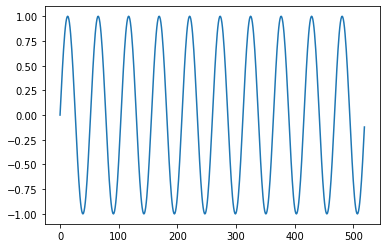

In [2]:
def wave(frequency, resolution, amplitude, fn=np.sin):
    length = np.pi * 2 * frequency
    my_wave = fn(np.arange(0, length, length / resolution))
    return my_wave * amplitude

series = wave(10, 520, 1)
plt.plot(series)
plt.show()

In [3]:
def plot(series: list, labels: list, show=True, ax = None, title = ''):
    if ax == None:
        plt.figure(figsize = (15, 6))
    for i, s in enumerate(series):
        module, title_fn = (plt, plt.title) if ax == None else (ax, ax.set_title)
        title_fn(title)
        module.plot(s, label=labels[i])
    if show:
        plt.legend(bbox_to_anchor =(1.25, 1))
        plt.show()
        
def plot_px(series: list, labels: list, title = ''):
    fig = go.Figure(layout_title_text=title)
    for i, data in enumerate(series):
        data = pd.Series(data)
        fig = fig.add_trace(Scatter(x = data.index, y = data, mode='lines', name=f'{labels[i]}'))
    fig.show()

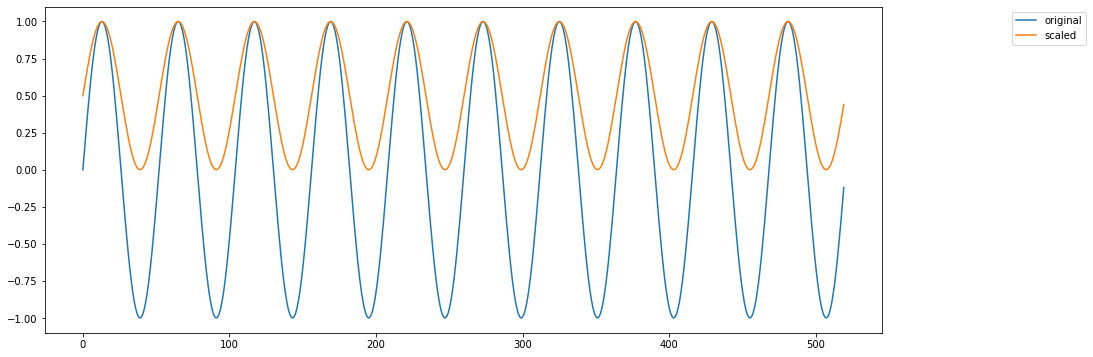

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series.reshape(-1, 1)).reshape(-1)
plot([series, scaled_series], ['original', 'scaled'])

In [5]:
def prepare_lags(series: np.array, lags: int):
    range_right = lags + 1
    series_df = pd.Series(series)
    lagged_series = {f'y - {range_right - i}':series_df.shift(range_right - i) for i in range(1, range_right)}
    lagged_series_df = pd.DataFrame(lagged_series)
    lagged_series_df['y'] = series
    lagged_series_df = lagged_series_df.dropna()
    
    return lagged_series_df

lagged_series_df = prepare_lags(scaled_series, lags=1)
lagged_series_df.head(5)

,y - 1,y
1,0.500000,0.560268
2,0.560268,0.619658
3,0.619658,0.677302
4,0.677302,0.732362
5,0.732362,0.784032


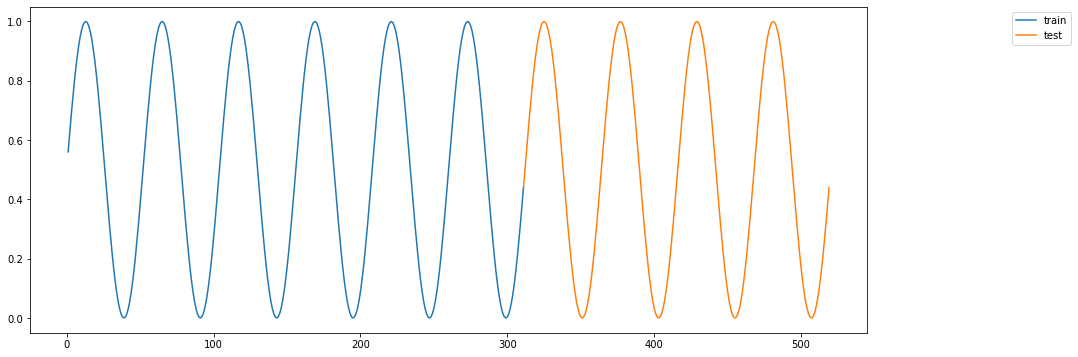

In [6]:
def split_test(series_df: pd.DataFrame, split_percentage: float):
    train_len = int(len(series_df) * split_percentage)
    train_df = series_df.loc[:train_len]
    test_df = series_df.loc[train_len:]
    
    return train_df.values[:, :-1], train_df.values[:, -1], test_df.values[:, :-1], test_df.values[:, -1], train_df, test_df

X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)
plot([train_df['y'], test_df['y']], labels=['train', 'test'])

In [7]:
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
tf.config.set_visible_devices([], 'GPU')

from tensorflow import keras
from keras import layers, activations, optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

In [8]:
def root_mean_squared_error(y, y_pred):
    return math.sqrt(mean_squared_error(y, y_pred))

def evaluate(y_test, forecast, show=True, ax=None):
    error = root_mean_squared_error(y_test, forecast)
    plot([y_test, forecast], ['actual', 'predicted'], show=show, ax=ax, title=f'error: {error}')
    
def unscale(series: np.array, scaler: MinMaxScaler):
    return scaler.inverse_transform(series.reshape(-1, 1)).reshape(-1)
    
def run_model(
    model_layers: list, 
    X_train: np.array, 
    y_train: np.array, 
    X_test: np.array, 
    y_test: np.array, 
    epochs:int,
    batch_size=32, 
    name='',
    early_stop=True,
    learning_rate=0.001,
    verbose=True
    ):
    
    early_stop_cb = EarlyStopping(
        monitor = 'val_loss', min_delta = 0.0001,
        patience = 30, mode = 'min', verbose = verbose,
        restore_best_weights = True)
    
    model = keras.models.clone_model(keras.Sequential(model_layers, name=name))
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = learning_rate), loss='mean_squared_error')

    history = model.fit(
        X_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=False,
        callbacks=[early_stop_cb] if early_stop else []
        )

    forecast = model.predict(X_test, verbose=verbose)    
    return forecast, history, model

def evaluate_model(
    run_times: int,
    model_layers: list, 
    X_train: np.array, 
    y_train: np.array, 
    X_test: np.array, 
    y_test: np.array, 
    epochs:int,
    scaler: MinMaxScaler,
    batch_size=32,
    name='',
    early_stop=True, 
    learning_rate=0.001,
    verbose=True,
    print_plot=True,
    print_summary=True
    ):
    
    errors = []
    forecasts = []
    models = []
    histories = []
    y_test_unscaled = unscale(y_test, scaler)
    
    for _ in range(run_times):
        forecast, history, model = run_model(
            model_layers, 
            X_train, y_train, X_test, y_test,
            epochs=epochs, 
            batch_size=batch_size,
            name=name,
            early_stop=early_stop,
            learning_rate=learning_rate,
            verbose=verbose
        )

        forecast = unscale(forecast, scaler)
        error = root_mean_squared_error(y_test_unscaled, forecast)
        errors.append(error)
        forecasts.append(forecast)
        models.append(model)
        histories.append(history)
        
    error_avg = np.array(errors).mean()
    error_std = np.array(errors).std()
    if print_summary:        
        models[0].summary()
        print(f'errors: {errors}')
        print(f'error avg: {error_avg}')    
        print(f'error std: {error_std}')
    
    if print_plot:
        _, ax = plt.subplots(1, len(histories), figsize=(25,6))
        for i, history in enumerate(histories):
            plot([history.history['loss'], history.history['val_loss']], labels=['loss', 'val_loss'], ax=ax[i], show=False)
        plt.legend(bbox_to_anchor =(1.25, 1))
        plt.show()
            
        plot([y_test_unscaled] + forecasts, ['actual'] + [f'prediction_{i}' for i in range(len(forecast))])
        plot_px([y_test_unscaled] + forecasts, ['actual'] + [f'prediction_{i}' for i in range(len(forecast))])
    
    return { name: (errors, error_avg, error_std) }

def baseline(test_series):
    _, ax = plt.subplots(1, 2, figsize=(25,6))
    evaluate(test_series, [test_series.mean()] * len(test_series), show=False, ax=ax[0])
    evaluate(test_series[1:], pd.DataFrame(test_series).shift(1).dropna(), show=False, ax=ax[1])
    plt.legend(bbox_to_anchor =(1.25, 1))
    plt.show()

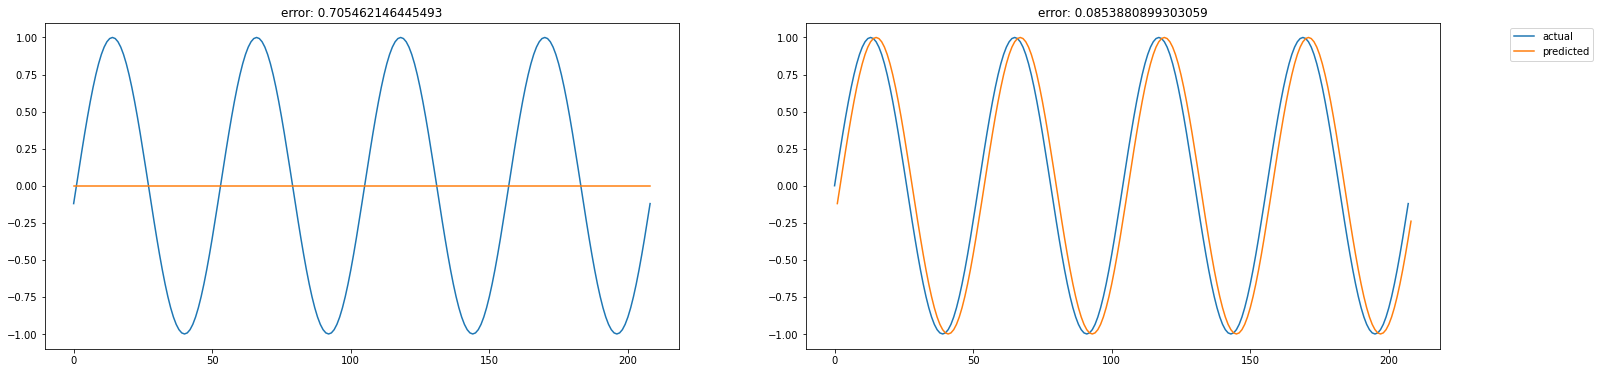

In [9]:
y_test_unscaled = unscale(y_test, scaler)
baseline(y_test_unscaled)

In [ ]:
from tensorflow import keras

lags = 1
lagged_series_df = prepare_lags(scaled_series, lags=lags)
X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)

lags1_results = evaluate_model(
    5,
    [
        layers.Dense(5, activation=activations.elu),
        layers.Dense(1, activation=activations.linear)
    ], 
    X_train, y_train, X_test, y_test,
    epochs=200,
    batch_size=32,
    name=f'Simple_MLP_{lags}_lags',
    scaler=scaler,
    early_stop=True,
    learning_rate=0.01,
    verbose=False,
    print_summary=True
)

In [ ]:
lags=2
lagged_series_df = prepare_lags(scaled_series, lags=lags)
lagged_series_df.head(10)

In [ ]:
lags = 2
lagged_series_df = prepare_lags(scaled_series, lags=lags)
X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)

lags2_results = evaluate_model(
    5,
    [
        layers.Dense(5, activation=activations.elu),
        layers.Dense(1, activation=activations.linear)
    ], 
    X_train, y_train, X_test, y_test,
    epochs=200,
    batch_size=32,
    name=f'Simple_MLP_{lags}_lags',
    scaler=scaler,
    early_stop=True,
    learning_rate=0.01,
    verbose=False,
    print_summary=True
)

In [ ]:
lags = 3
lagged_series_df = prepare_lags(scaled_series, lags=lags)
X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)

lags3_results = evaluate_model(
    10,
    [
        layers.Dense(5, activation=activations.elu),
        layers.Dense(1, activation=activations.linear)
    ], 
    X_train, y_train, X_test, y_test,
    epochs=200,
    batch_size=32,
    name=f'Simple_MLP_{lags}_lags',
    scaler=scaler,
    early_stop=True,
    learning_rate=0.01,
    verbose=False,
    print_summary=True
)

In [ ]:
def noise(resolution, std, amplitude = 1):
    return np.random.normal(0, std, resolution) * amplitude

resolution = 520
noisy_sin_series = wave(10, resolution, 1) + noise(resolution, 0.1)
plt.plot(noisy_sin_series)
plt.show()

In [ ]:
lags = 2
scaled_series = scaler.fit_transform(noisy_sin_series.reshape(-1, 1)).reshape(-1)
lagged_series_df = prepare_lags(scaled_series, lags=lags)
X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)

y_test_unscaled = unscale(y_test, scaler)
baseline(y_test_unscaled)

In [ ]:
lags2_results = evaluate_model(
    5,
    [
        layers.Dense(5, activation=activations.elu),
        layers.Dense(1, activation=activations.linear)
    ], 
    X_train, y_train, X_test, y_test,
    epochs=200,
    batch_size=32,
    name=f'Simple_MLP_{lags}_lags',
    scaler=scaler,
    early_stop=True,
    learning_rate=0.01,
    verbose=False,
    print_summary=True
)

In [ ]:
lags=4
lagged_series_df = prepare_lags(scaled_series, lags=lags)
X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)

lags4_results = evaluate_model(
    5,
    [
        layers.Dense(5, activation=activations.elu),
        layers.Dense(1, activation=activations.linear)
    ], 
    X_train, y_train, X_test, y_test,
    epochs=200,
    batch_size=32,
    name=f'Simple_MLP_{lags}_lags',
    scaler=scaler,
    early_stop=True,
    learning_rate=0.01,
    verbose=False,
    print_summary=True
)

In [ ]:
lags=10
lagged_series_df = prepare_lags(scaled_series, lags=lags)
X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)

lags10_results = evaluate_model(
    5,
    [
        layers.Dense(5, activation=activations.elu),
        layers.Dense(1, activation=activations.linear)
    ], 
    X_train, y_train, X_test, y_test,
    epochs=200,
    batch_size=32,
    name=f'Simple_MLP_{lags}_lags',
    scaler=scaler,
    early_stop=True,
    learning_rate=0.01,
    verbose=False,
    print_summary=True
)

In [ ]:
lags=20
lagged_series_df = prepare_lags(scaled_series, lags=lags)
X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)

lags20_results = evaluate_model(
    5,
    [
        layers.Dense(5, activation=activations.elu),
        layers.Dense(1, activation=activations.linear)
    ], 
    X_train, y_train, X_test, y_test,
    epochs=200,
    batch_size=32,
    name=f'Simple_MLP_{lags}_lags',
    scaler=scaler,
    early_stop=True,
    learning_rate=0.01,
    verbose=False,
    print_summary=True
)

In [ ]:
lags=20
lags20_results_noise_MLP = evaluate_model(
    5,
    [
        layers.Dense(10, activation=activations.elu),
        layers.Dense(100, activation=activations.elu),
        layers.Dense(10, activation=activations.elu),
        layers.Dense(1, activation=activations.linear)
    ], 
    X_train, y_train, X_test, y_test,
    epochs=200,
    batch_size=32,
    name=f'MLP_{lags}_lags',
    scaler=scaler,
    early_stop=True,
    learning_rate=0.01,
    verbose=False,
    print_summary=True
)

In [ ]:
def evaluate_all_models(X_train, y_train, X_test, y_test, scaler, verbose=False, plot=True, print_summary=True, first_hidden_num=10):
    lags = X_train.shape[1]
    result = {}

    result.update(evaluate_model(
        5,
        [
            layers.Dense(first_hidden_num, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train, y_train, X_test, y_test,
        epochs=200,
        batch_size=32,
        name=f'Simple_MLP_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.Dense(first_hidden_num, activation=activations.elu),
            layers.Dense(100, activation=activations.elu),
            layers.Dense(10, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train, y_train, X_test, y_test,
        epochs=200,
        batch_size=32,
        name=f'Deep_MLP_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.Dense(first_hidden_num, activation=activations.elu),
            layers.Dense(100, activation=activations.elu),
            layers.Dropout(0.1),
            layers.Dense(10, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train, y_train, X_test, y_test,
        epochs=200,
        batch_size=32,
        name=f'Deep_MLP_Dropout_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.SimpleRNN(first_hidden_num, activation=activations.elu),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1], 1),
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], 1), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'RNN_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.SimpleRNN(20, activation=activations.elu, return_sequences=True),
            layers.SimpleRNN(10, activation=activations.elu),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], 1), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'RNN_RNN_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.LSTM(first_hidden_num, activation=activations.elu),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], 1), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'LSTM_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.GRU(first_hidden_num, activation=activations.elu),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], 1), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'GRU_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.Conv1D(64, kernel_size=math.ceil(lags / 2.), activation=activations.relu),
            layers.Flatten(),
            layers.Dropout(0.1),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], 1), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'CNN_Dropout_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.Conv1D(64, kernel_size=math.ceil(lags / 2.), activation=activations.relu),
            layers.Flatten(),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], 1), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'CNN_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.01,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))
    
    result2 = np.array([[k, v[1], v[2]] for k,v in zip(result.keys(), result.values())])
    return pd.DataFrame({'avg': result2[:, 1], 'std': result2[:, 2]}, index = result2[:, 0])

In [ ]:
lags=20
lagged_series_df = prepare_lags(scaled_series, lags=lags)
X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)
result_20_lags_all_models = evaluate_all_models(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler, verbose=False, plot=False, print_summary=False, first_hidden_num=lags)
result_20_lags_all_models

In [ ]:
def fft(series):
    n = len(series)
    fft = np.fft.fft(series, n)
    PSD = fft * np.conj(fft) / n
    
    return PSD.real

def plot_with_dft(series: np.array):
    _, ax = plt.subplots(1, 2, figsize=(25,6))
    ax[0].plot(series)
    ax[0].set_title('series')
    ax[1].plot(fft(series))
    ax[1].set_title('fourier components')
    plt.show()

def new_series(series, scaler, lags=10):
    plot_with_dft(series)

    scaled_series = scaler.fit_transform(series.reshape(-1, 1)).reshape(-1)
    lagged_series_df = prepare_lags(scaled_series, lags=lags)
    X_train, y_train, X_test, y_test, train_df, test_df = split_test(lagged_series_df, 0.6)

    y_test_unscaled = unscale(y_test, scaler)
    
    _, ax = plt.subplots(1, 2, figsize=(25,6))
    evaluate(y_test_unscaled, [y_test_unscaled.mean()] * len(y_test_unscaled), show=False, ax=ax[0])
    evaluate(y_test_unscaled[1:], pd.DataFrame(y_test_unscaled).shift(1).dropna(), show=False, ax=ax[1])
    plt.legend(bbox_to_anchor =(1.25, 1))
    plt.show()
    
    return series, X_train, y_train, X_test, y_test, lagged_series_df

In [ ]:
def fading_wave(frequency, resolution, amplitude, fn=np.sin, reverse=True):
    my_wave = wave(frequency, resolution, amplitude, fn)
    fading_amplitude = np.linspace(0, 1, resolution)
    if(reverse):
        fading_amplitude = np.flip(fading_amplitude)
    return my_wave * fading_amplitude

resolution = 520

In [ ]:
lags=20
fading_series_noise1, X_train, y_train, X_test, y_test, lagged_series_df = new_series(
    fading_wave(10, resolution, 1) + noise(resolution, 0.1),
    scaler, 
    lags=lags)

In [ ]:
fading_result_20_lags_all_models = evaluate_all_models(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler, verbose=False, plot=False, print_summary=False, first_hidden_num=20)
fading_result_20_lags_all_models

In [ ]:
def trend(length, c1 = 1.0, c2 = 0.0, amplitude = 1.0):
    xs = np.linspace(0, 1, length)
    ys = 1.0 / (1 + np.exp(-c1 * (xs - c2)))
    return ys * amplitude

In [ ]:
complex_series_noise3, X_train, y_train, X_test, y_test, lagged_series_df = new_series(
    trend(resolution, -4, 0, 10) +
    wave(10, resolution, 1) + 
    wave(20, resolution, 3) + 
    wave(5, resolution, 2, np.cos) + 
    noise(resolution, 3),
    scaler,
    lags=lags)

In [ ]:
complex_noise3_result_20_lags_all_models = evaluate_all_models(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler, verbose=False, plot=False, print_summary=False, first_hidden_num=20)
complex_noise3_result_20_lags_all_models

In [ ]:
lags=20
complex_fasing_series_noise3, X_train, y_train, X_test, y_test, lagged_series_df = new_series(
    trend(resolution, -4, 0, 10) +
    fading_wave(20, resolution, 3, reverse = True) + 
    fading_wave(10, resolution, 3) + 
    wave(5, resolution, 2, np.cos) + 
    noise(resolution, 1),
    scaler, 
    lags=lags)

In [ ]:
fading_complex_noise1_result_20_lags_all_models = evaluate_all_models(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler, verbose=False, plot=False, print_summary=False, first_hidden_num=20)
fading_complex_noise1_result_20_lags_all_models

In [ ]:
resolution = 520
realistic_series_noise6, X_train, y_train, X_test, y_test, lagged_series_df = new_series(
    trend(resolution, -4, 0, 10) +
    wave(10, resolution, 3, np.cos) + 
    wave(20, resolution, 2, np.cos) +
    wave(5, resolution, 2.5, np.sin) + 
    wave(200, resolution, 3, np.sin) + 
    wave(400, resolution, 2, np.sin) + 
    wave(100, resolution, 2, np.sin) + 
    wave(50, resolution, 3, np.sin) +
    noise(resolution, 6),
    scaler, 
    lags=lags)

In [ ]:
realistic_noise6_result_20_lags_all_models = evaluate_all_models(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler, verbose=False, plot=False, print_summary=False, first_hidden_num=20)
realistic_noise6_result_20_lags_all_models

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

p1 = plot_acf(complex_series_noise3, lags=52, title='Complex series autocorrelation')
p2 = plot_acf(realistic_series_noise6, lags=52, title='Realistic series autocorrelation')

In [ ]:
def prepare_data_multivariate(series: np.array):
    series = pd.Series(series)
    series_averages_df = pd.DataFrame({'y-1':series})
    series_averages_df['y4'] = series.rolling(window = 4).mean()
    series_averages_df['y12'] = series.rolling(window = 12).mean()
    
    acf_array = acf(series, nlags=52)
    shift_value = (acf_array[12:].argmax() + 12)
    
    series_averages_df['py'] = series.shift(shift_value - 1)
    series_averages_df['py4'] = series_averages_df['y4'].shift(shift_value - 4)
    series_averages_df['py12'] = series_averages_df['y12'].shift(shift_value - 12)
    series_averages_df['y'] = series.shift(-1)
    
    return series_averages_df.dropna()

In [ ]:
multi_series: pd.DataFrame = prepare_data_multivariate(complex_series_noise3)
multi_series.head(10)

plot([multi_series['y'], multi_series['y-1'], multi_series['y4'], multi_series['y12'], multi_series['py'], multi_series['py4'], multi_series['py12']], labels=['y','y-1','y4','y12','py','py4','py12'])
plot_px([multi_series['y'], multi_series['y-1'], multi_series['y4'], multi_series['y12'], multi_series['py'], multi_series['py4'], multi_series['py12']], labels=['y','y-1','y4','y12','py','py4','py12'])

In [ ]:
[
    layers.Conv2D(64, kernel_size=(10,5), input_shape=(X_train.shape[1], X_train.shape[2], 1), activation=activations.relu, padding='same'),
    layers.MaxPooling2D(pool_size=(2,2), strides=[2, 2]),
    layers.Conv2D(64, kernel_size=(5,3), activation=activations.relu),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(5, activation=activations.elu),
    layers.Dense(1, activation=activations.linear)
]

In [ ]:
def prepare_lags_multivariate(series: pd.DataFrame, lags: int):
    range_right = lags + 1
    lags_data = np.array([series.shift(range_right - i) for i in range(1, range_right)])
    lags_data = lags_data.transpose(1, 0, 2)
    lags_data = np.array(list(filter(lambda x: not np.isnan(x).any(), lags_data)))
    
    return lags_data, lags_data[:, :, :-1], lags_data[:, :, -1]

def split_test_multivariate(series: np.array, split_percentage=0.8):
    train_len = int(len(series) * split_percentage)
    train = series[:train_len]
    test = series[train_len:]
    
    return train[:, :, :-1], train[:, -1, -1], test[:, :, :-1], test[:, -1, -1], train, test

def new_series_multivariate(series: np.array, scaler: MinMaxScaler, lags=10):
    _, ax = plt.subplots(1, 2, figsize=(25,6))
    ax[0].plot(series)
    ax[0].set_title('series')
    ax[1].plot(fft(series))
    ax[1].set_title('fourier components')
    plt.show()

    scaled_series = scaler.fit_transform(series.reshape(-1, 1)).reshape(-1)
    multivariate_series = prepare_data_multivariate(scaled_series)
    lagged_series, _, _ = prepare_lags_multivariate(multivariate_series, lags=lags)
    X_train, y_train, X_test, y_test, train_df, test_df = split_test_multivariate(lagged_series, 0.6)

    y_test_unscaled = unscale(y_test, scaler)
    
    _, ax = plt.subplots(1, 2, figsize=(25,6))
    evaluate(y_test_unscaled, [y_test_unscaled.mean()] * len(y_test_unscaled), show=False, ax=ax[0])
    evaluate(y_test_unscaled[1:], pd.DataFrame(y_test_unscaled).shift(1).dropna(), show=False, ax=ax[1])
    plt.legend(bbox_to_anchor =(1.25, 1))
    plt.show()
    
    return series, X_train, y_train, X_test, y_test, lagged_series_df

def evaluate_all_models_multivariate(X_train, y_train, X_test, y_test, scaler, verbose=False, plot=True, print_summary=True, first_hidden_num=20):
    lags = X_train.shape[1]
    result = {}

    result.update(evaluate_model(
        5,
        [
            layers.Dense(first_hidden_num, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'Simple_MLP_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.Dense(first_hidden_num, activation=activations.elu),
            layers.Dense(100, activation=activations.elu),
            layers.Dense(10, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'Deep_MLP_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.Dense(first_hidden_num, activation=activations.elu),
            layers.Dense(100, activation=activations.elu),
            layers.Dropout(0.1),
            layers.Dense(10, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]), 
        y_test,
        epochs=200,
        batch_size=32,
        name=f'Deep_MLP_Dropout_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.SimpleRNN(first_hidden_num, activation=activations.elu),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train, y_train, X_test, y_test,
        epochs=200,
        batch_size=32,
        name=f'RNN_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.SimpleRNN(20, activation=activations.elu, return_sequences=True),
            layers.SimpleRNN(10, activation=activations.elu),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train, y_train, X_test, y_test,
        epochs=200,
        batch_size=32,
        name=f'RNN_RNN_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.LSTM(first_hidden_num, activation=activations.elu),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train, y_train, X_test, y_test,
        epochs=200,
        batch_size=32,
        name=f'LSTM_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.GRU(first_hidden_num, activation=activations.elu),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train, y_train, X_test, y_test,
        epochs=200,
        batch_size=32,
        name=f'GRU_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))

    result.update(evaluate_model(
        5,
        [
            layers.Conv2D(64, kernel_size=(5,3), activation=activations.relu, padding='same'),
            layers.Flatten(),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ], 
        X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1), 
        y_test, 
        epochs=200,
        batch_size=32,
        name=f'CNN_2D_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))
    
    result.update(evaluate_model(
        5,
        [
            layers.Conv2D(64, kernel_size=(5,3), activation=activations.relu, padding='same'),
            layers.Flatten(),
            layers.Dropout(0.1),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ],
        X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1), 
        y_test, 
        epochs=200,
        batch_size=32,
        name=f'Dropout_CNN_2D_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))
    
    result.update(evaluate_model(
        5,
        [
            layers.Conv2D(64, kernel_size=(10,5), input_shape=(X_train.shape[1], X_train.shape[2], 1), activation=activations.relu, padding='same'),
            layers.MaxPooling2D(pool_size=(2,2), strides=[2, 2]),
            layers.Conv2D(64, kernel_size=(5,3), activation=activations.relu),
            layers.Flatten(),
            layers.Dropout(0.1),
            layers.Dense(5, activation=activations.elu),
            layers.Dense(1, activation=activations.linear)
        ],
        X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
        y_train, 
        X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1), 
        y_test, 
        epochs=200,
        batch_size=32,
        name=f'Deep_CNN_2D_{lags}_lags',
        scaler=scaler,
        early_stop=True,
        learning_rate=0.005,
        verbose=verbose,
        print_plot=plot,
        print_summary=print_summary
    ))
    
    
    result2 = np.array([[k, v[1], v[2]] for k,v in zip(result.keys(), result.values())])
    return pd.DataFrame({'avg': result2[:, 1], 'std': result2[:, 2]}, index = result2[:, 0])

In [ ]:
complex_series_noise3_multivariate, X_train, y_train, X_test, y_test, lagged_series_df = new_series_multivariate(complex_series_noise3, scaler, lags)
complex_multivariate_noise3_result_20_lags_all_models = evaluate_all_models_multivariate(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler, verbose=False, plot=False, print_summary=False)
complex_multivariate_noise3_result_20_lags_all_models

In [ ]:
realistic_noise6_multivariate, X_train, y_train, X_test, y_test, lagged_series_df = new_series_multivariate(realistic_series_noise6, scaler, lags)
realistic_noise6_multivariate_result_20_lags_all_models = evaluate_all_models_multivariate(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler, verbose=False, plot=False, print_summary=False)
realistic_noise6_multivariate_result_20_lags_all_models

In [ ]:
def prepare_lags(series: np.array, lags: int):
    range_right = lags + 1
    series_df = pd.Series(series)
    lagged_series = {f'y - {range_right - i}':series_df.shift(range_right - i) for i in range(1, range_right)}
    lagged_series_df = pd.DataFrame(lagged_series)
    lagged_series_df['y'] = series
    lagged_series_df = lagged_series_df.dropna()
    
    return lagged_series_df

lagged_series_df = prepare_lags(scaled_series, lags=1)
lagged_series_df.head(5)

In [ ]:
lags=20
complex_fasing_series_noise3_multivariate, X_train, y_train, X_test, y_test, lagged_series_df = new_series_multivariate(
    complex_fasing_series_noise3,
    scaler, 
    lags=lags)
complex_fasing_series_noise3_multivariate_result_20_lags_all_models = evaluate_all_models_multivariate(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler, verbose=False, plot=False, print_summary=False)
complex_fasing_series_noise3_multivariate_result_20_lags_all_models